# Explore here

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split

import warnings

In [16]:
# reading and saving the data
url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
rawdata = pd.read_csv(url)
rawdata.to_csv('../data/raw/sales_raw.csv')

In [17]:
rawdata.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


##### We can observe that tensor = Days (YYYY-MM-DD) is the minimum time unit of the data (given that there are no entries on the same day)

In [18]:
rawdata['date'] = pd.to_datetime(rawdata['date']).dt.floor("d")
rawdata.head(10)

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633
5,2022-09-08,60.081865
6,2022-09-09,68.466704
7,2022-09-10,67.765106
8,2022-09-11,70.512261
9,2022-09-12,74.656453


In [19]:
rawdata = rawdata.set_index("date")
df = rawdata
df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


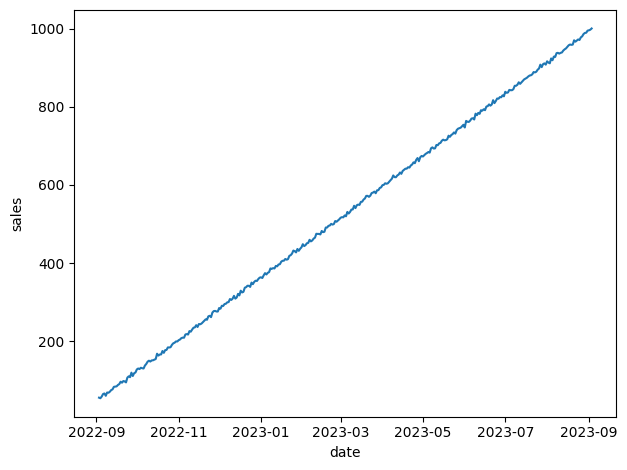

In [20]:
sns.lineplot(x=df.index, y= df['sales']) # type : ignore
plt.tight_layout()

plt.show()

In [21]:
sales = df['sales']

sales.head()

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Name: sales, dtype: float64

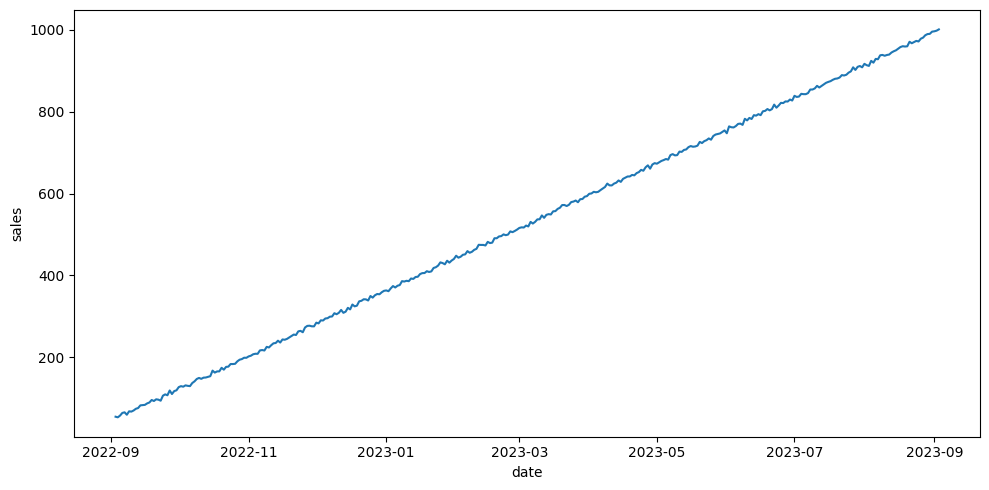

In [22]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales)

plt.tight_layout()

plt.show()

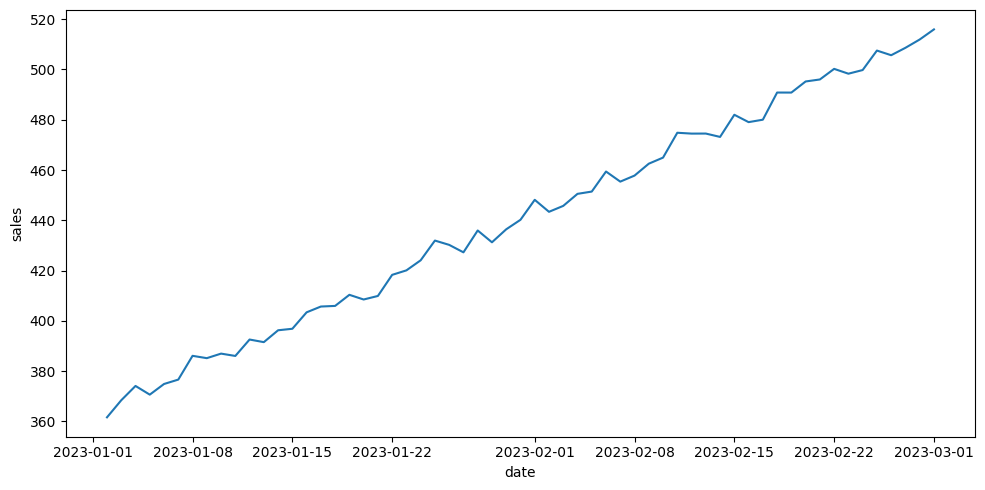

In [23]:
start_date = "2023-01"
end_date = "2023-03"

# selecciono periodo de observación
periodo = (sales.index> start_date) & (sales.index <= end_date)

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales.loc[periodo])

plt.tight_layout()

plt.show()

Tensor: días (secs?)    

Tendencia: Ascendente

Estacionaria: Sí 

Variabilidad/ruido: Sí


In [24]:
decomp = seasonal_decompose(sales, period = 52) 
decomp

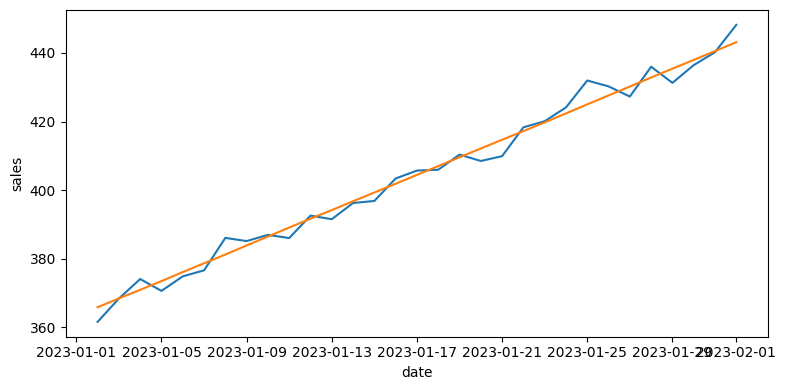

In [25]:
trend = decomp.trend

# defino periodo
start_date = "2023-01"
end_date = "2023-02"
periodo = (sales.index> start_date) & (sales.index <= end_date)

# plot
fig, axis = plt.subplots(figsize = (8, 4))
sns.lineplot(data = sales[periodo])
sns.lineplot(data = trend[periodo])
plt.tight_layout()
plt.show()

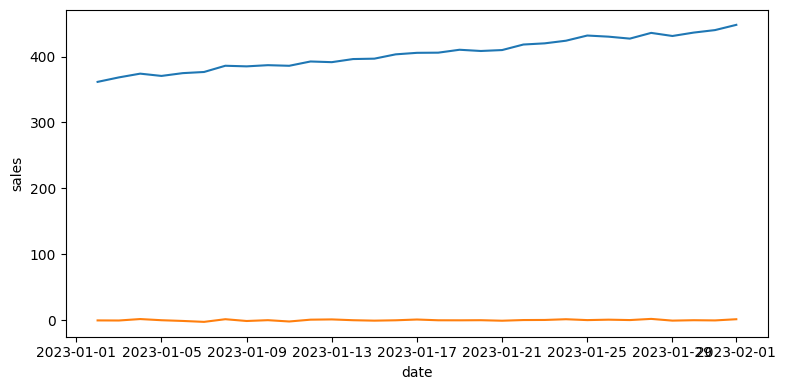

In [26]:
season = decomp.seasonal

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales[periodo])
sns.lineplot(data = season[periodo])

plt.tight_layout()

plt.show()


### claramente no hay estacionalidad

In [27]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [28]:
test_stationarity(sales)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

In [29]:
print(sales)

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, Length: 366, dtype: float64


In [30]:
# Diferenciar la serie para remover tendencia
sales_diff = sales.diff().dropna()

sales_diff



date
2022-09-04   -1.488946
2022-09-05    4.338482
2022-09-06    6.389205
2022-09-07    1.482734
2022-09-08   -5.931768
                ...   
2023-08-30    0.518681
2023-08-31    5.386972
2023-09-01    0.827090
2023-09-02    1.535798
2023-09-03    3.132571
Name: sales, Length: 365, dtype: float64

In [31]:
test_stationarity(sales_diff)




Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

### la serie es absolutamente estacionaria y no estacional (el p value para la prueba DF de la serie diff es casi 0)

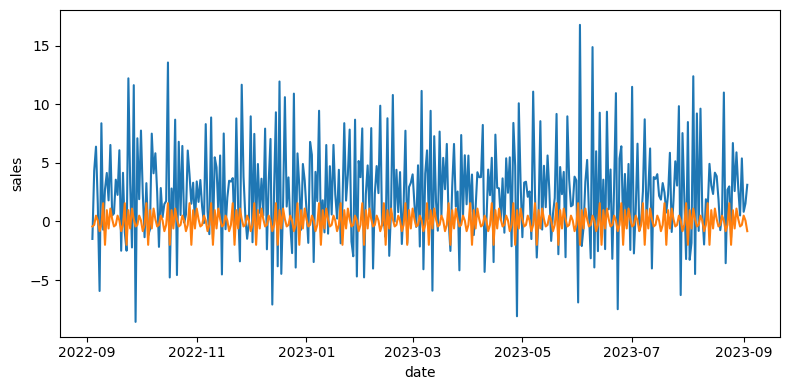

In [32]:
sales_diff_decomp = seasonal_decompose(sales_diff, period=12)

sales_diff_season = sales_diff_decomp.seasonal

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales_diff)
sns.lineplot(data = sales_diff_season)

plt.tight_layout()

plt.show()

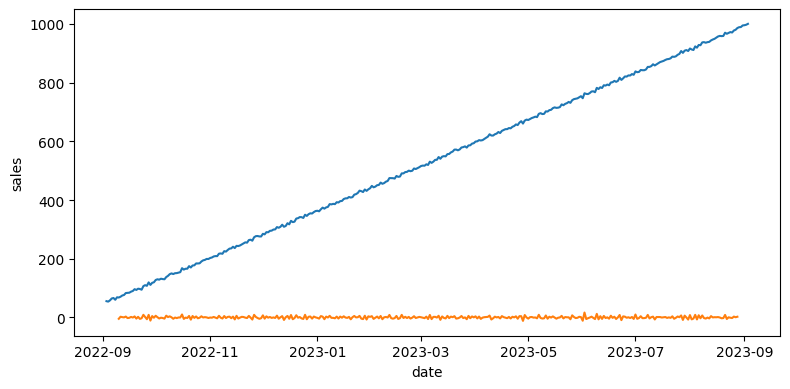

In [33]:
residual = sales_diff_decomp.resid

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

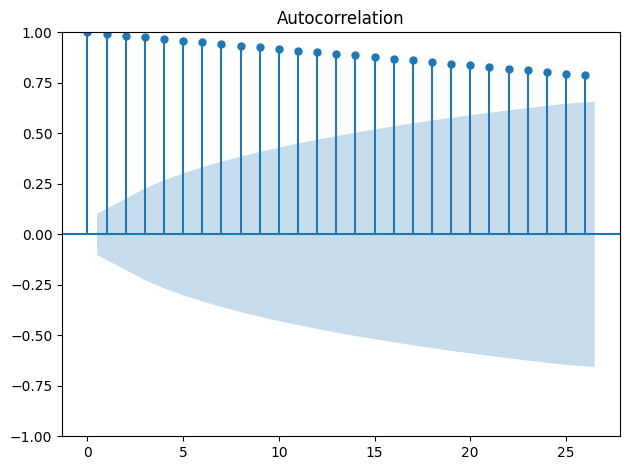

In [34]:
plot_acf(sales)

plt.tight_layout()
plt.show()

In [35]:
model = auto_arima(sales, seasonal = False, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.229, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.575 seconds


In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Mon, 05 Aug 2024   AIC                           1839.552
Time:                        20:40:40   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
forecast = model.predict(30)    
forecast

2023-09-04    1002.158148
2023-09-05    1004.831668
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217253
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
2023-09-14    1028.206408
2023-09-15    1030.804239
2023-09-16    1033.402070
2023-09-17    1035.999902
2023-09-18    1038.597733
2023-09-19    1041.195564
2023-09-20    1043.793395
2023-09-21    1046.391226
2023-09-22    1048.989057
2023-09-23    1051.586888
2023-09-24    1054.184719
2023-09-25    1056.782550
2023-09-26    1059.380381
2023-09-27    1061.978212
2023-09-28    1064.576043
2023-09-29    1067.173874
2023-09-30    1069.771705
2023-10-01    1072.369536
2023-10-02    1074.967367
2023-10-03    1077.565198
Freq: D, dtype: float64

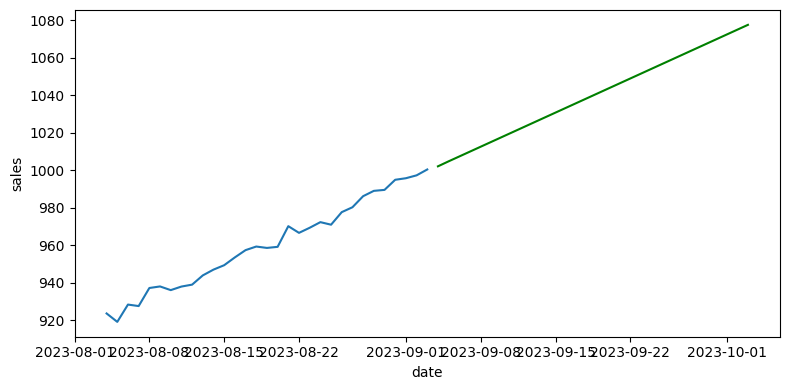

In [38]:
# defino periodo
start_date = "2023-08-03"
end_date = "2023-09-08"
periodo = (sales.index> start_date) & (sales.index <= end_date)

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales[periodo])
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [39]:
sales.head()

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Name: sales, dtype: float64

In [40]:
sales.tail()


date
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, dtype: float64

In [41]:
# defino entrenamiento
start_date = "2022-09-03"
end_date = "2023-07-03"
inicio = (sales.index> start_date) & (sales.index <= end_date)

train = sales[inicio]
train



date
2022-09-04     53.803211
2022-09-05     58.141693
2022-09-06     64.530899
2022-09-07     66.013633
2022-09-08     60.081865
                 ...    
2023-06-29    829.329346
2023-06-30    826.902337
2023-07-01    838.399050
2023-07-02    835.672905
2023-07-03    836.589602
Name: sales, Length: 303, dtype: float64

In [42]:
# defino testeo
start_date = "2023-07-04"
end_date = "2023-09-03"
final = (sales.index> start_date) & (sales.index <= end_date)

test = sales[final]
test

date
2023-07-05     842.453457
2023-07-06     842.435581
2023-07-07     845.000943
2023-07-08     853.725155
2023-07-09     853.767855
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, Length: 61, dtype: float64

In [43]:
arima_model = auto_arima(train, seasonal = False, trace = True)

arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1534.556, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1746.049, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1643.151, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1531.314, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1836.592, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1530.724, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1532.631, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1534.619, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1530.638, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1532.582, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1801.417, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.495 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  303
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -761.319
Date:                Mon, 05 Aug 2024   AIC                           1530.638
Time:                        20:40:42   BIC                           1545.480
Sample:                    09-04-2022   HQIC                          1536.576
                         - 07-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5994      0.012    225.792      0.000       2.577       2.622
ma.L1         -1.0359      0.053    -19.451      0.000      -1.140      -0.932
ma.L2          0.0989      0.053      1.865      0.062      -0.005       0.203
sigma2         8.9947      0.797     11.280      0.000       7.432      10.558
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.99   Prob(JB):                         0.55
Heteroskedasticity (H):               0.88   Skew:                             0.05
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
test_prediction = arima_model.predict(60)

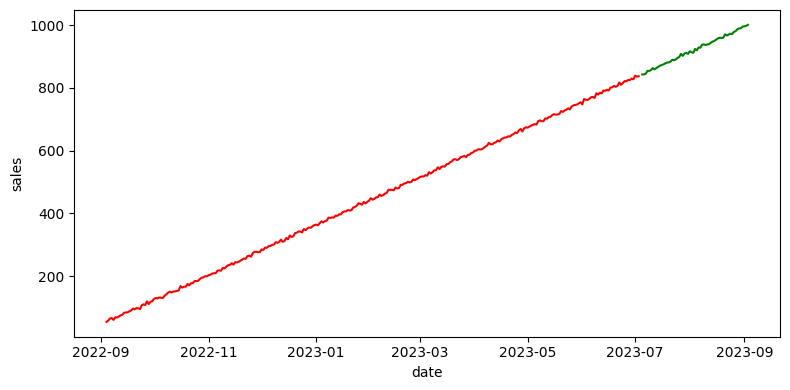

In [45]:
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = train, c='red')
sns.lineplot(data = test, c = "green")

plt.tight_layout()

plt.show()

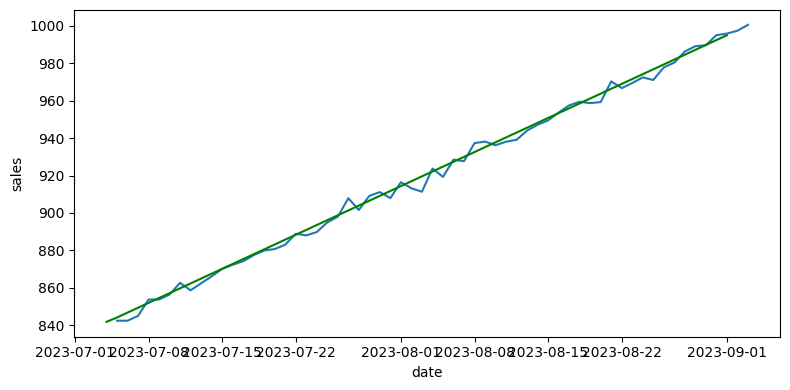

In [46]:
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = test)
sns.lineplot(data = test_prediction, c = "green")

plt.tight_layout()

plt.show()

In [47]:
from pickle import dump

dump(arima_model, open('../models/arima_primero.pkl','wb' ))
